We import ‘tensorflow' to access the core TensorFlow functionality, ‘Tokenizer' to preprocess text data by tokenizing it into sequences, and ‘pad_sequences' to pad the sequences to a fixed length.

In [215]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import numpy as np 
import random 
import json 
  
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
from datasets import load_dataset

In [216]:
# Loading Amazon Intent Dataset 
dataset = load_dataset("SetFit/amazon_massive_intent_en-US")
print(dataset.shape)

# # Separating out the datasets 
training_set = dataset['train'].to_pandas()
test_set = dataset['test'].to_pandas()

training_set.head()

{'train': (11514, 4), 'validation': (2033, 4), 'test': (2974, 4)}


,id,label,text,label_text
0,1,48,wake me up at nine am on friday,alarm_set
1,2,48,set an alarm for two hours from now,alarm_set
2,4,46,olly quiet,audio_volume_mute
3,5,46,stop,audio_volume_mute
4,6,46,olly pause for ten seconds,audio_volume_mute


In [217]:
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess_func (text):
   # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

def reassign_label_id (id):
    id_dict = {50:1, 45:2, 13:3, 32:4, 12:5, 49:6, 22:7, 44:8, 33:9, 0:10, 30:11, 36:12, 47:13, 26:14, 9:15}

    if id in id_dict:
        id = id_dict[id]
    return id 



In [218]:
# Finding out what are the top labels of the entire dataset
#  Will limit analysis to these labels  
concat_data = pd.concat([training_set , validation_set ,test_set])
print("Combined DF shape:", concat_data.shape)
top_15_labels = list(concat_data["label_text"].value_counts().head(15).index)

training_set = training_set[training_set['label_text'].isin(top_15_labels)]
training_set['preprocessed_txt'] = training_set['text'].apply(preprocess_func)
training_set['new_id'] = training_set['label'].apply(reassign_label_id)
print("New Training Set shape:", training_set.shape)

# validation_set = validation_set[validation_set['label_text'].isin(top_15_labels)]
# print("New Validation Set shape:", validation_set.shape)

test_set = test_set[test_set['label_text'].isin(top_15_labels)]
test_set['preprocessed_txt'] = test_set['text'].apply(preprocess_func)
test_set['new_id'] = test_set['label'].apply(reassign_label_id)
print("New Test Set shape:", test_set.shape)

# Separating X_train, X_test, y_train, and y_test
X_train = training_set['preprocessed_txt']
y_train = training_set['new_id']

X_test = test_set['preprocessed_txt']
y_test = test_set['new_id']


Combined DF shape: (15686, 4)
New Training Set shape: (6664, 6)
New Test Set shape: (1771, 6)


In [219]:
training_set[['label_text', 'new_id']].value_counts()

label_text       new_id
calendar_set     1         810
play_music       2         639
weather_query    3         573
calendar_query   4         566
general_quirky   5         555
qa_factoid       6         544
news_query       7         503
email_query      8         418
email_sendemail  9         354
datetime_query   10        350
calendar_remove  11        312
play_radio       12        283
social_post      13        283
qa_definition    14        267
cooking_recipe   15        207
Name: count, dtype: int64

In [220]:
X_train[:10]

21                      check start
22    want listen arijit singh song
23                  want play music
24                  check car ready
25                check laptop work
26        brightness screen run low
27      need location service check
28         check status power usage
29             tired actually happy
30        olly tired actually happy
Name: preprocessed_txt, dtype: object

In [221]:
training_set['text'][:10]

21                           check when the show starts
22        i want to listen arijit singh song once again
23                  i want to play that music one again
24                                check my car is ready
25                           check my laptop is working
26           is the brightness of my screen running low
27    i need to have location services on can you check
28                   check the status of my power usage
29                   i am not tired i am actually happy
30              olly i am not tired i am actually happy
Name: text, dtype: object

In [222]:
y_train[:10]

21    4
22    2
23    2
24    5
25    5
26    5
27    5
28    5
29    5
30    5
Name: new_id, dtype: int64

#### Approach #1: sklearn 

In [223]:
len(X_train.values)

6664

In [224]:
# Create bag of words representation using CountVectorizer

from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()

X_train_cv = v.fit_transform(X_train.values)
X_train_cv


<6664x3253 sparse matrix of type '<class 'numpy.int64'>'
	with 22515 stored elements in Compressed Sparse Row format>

In [225]:
X_train_cv.toarray()[:2][0]

array([0, 0, 0, ..., 0, 0, 0])

In [179]:
print(X_train_cv.shape)

print(y_train.shape)

(6664, 3253)
(6664,)


In [180]:
v.get_feature_names_out()[1226]

'guy'

In [182]:
v.vocabulary_

# As you can see, there are still a lot of stop words. I will try to remove them after the intital training step to see how it impacts performance 

{'check': 483,
 'start': 2767,
 'want': 3145,
 'listen': 1649,
 'arijit': 121,
 'singh': 2660,
 'song': 2711,
 'play': 2182,
 'music': 1912,
 'car': 426,
 'ready': 2353,
 'laptop': 1589,
 'work': 3211,
 'brightness': 342,
 'screen': 2563,
 'run': 2503,
 'low': 1688,
 'need': 1937,
 'location': 1663,
 'service': 2603,
 'status': 2778,
 'power': 2225,
 'usage': 3098,
 'tired': 2977,
 'actually': 25,
 'happy': 1251,
 'olly': 2031,
 'tell': 2923,
 'time': 2971,
 'moscow': 1892,
 'happen': 1249,
 'football': 1073,
 'today': 2988,
 'yesterday': 3239,
 'beatle': 232,
 'favorite': 1011,
 'good': 1181,
 'rain': 2325,
 'go': 1173,
 'currently': 683,
 'snow': 2698,
 'week': 3170,
 'weather': 3163,
 'news': 1953,
 'late': 1595,
 'like': 1634,
 'daft': 694,
 'punk': 2290,
 'coldplay': 558,
 'jazz': 1477,
 'playlist': 2184,
 'technology': 2918,
 'turn': 3051,
 'michael': 1829,
 'jackson': 1456,
 'beijing': 245,
 'shanghai': 2618,
 'date': 713,
 'day': 720,
 'outside': 2060,
 'barcelona': 210,
 'worl

In [183]:
X_train[:4]

21                      check start
22    want listen arijit singh song
23                  want play music
24                  check car ready
Name: preprocessed_txt, dtype: object

In [184]:
training_set['text'][:4]

21                       check when the show starts
22    i want to listen arijit singh song once again
23              i want to play that music one again
24                            check my car is ready
Name: text, dtype: object

In [185]:
# Train the naive bayes model

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_cv, y_train)

MultinomialNB()

In [186]:
X_test_cv = v.transform(X_test)

In [187]:
# Evaluate the performance

from sklearn.metrics import classification_report

y_pred = model.predict(X_test_cv)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        88
           9       0.95      0.81      0.87        72
          12       0.65      0.42      0.51       169
          13       0.85      0.95      0.89       156
          22       0.82      0.82      0.82       124
          26       0.95      0.72      0.82        57
          30       0.89      0.88      0.89        67
          32       0.62      0.48      0.54       126
          33       0.91      0.89      0.90       114
          36       0.92      0.75      0.82        72
          44       0.84      0.91      0.87       119
          45       0.82      0.95      0.88       176
          47       0.96      0.89      0.92        81
          49       0.75      0.60      0.66       141
          50       0.60      0.93      0.73       209

    accuracy                           0.79      1771
   macro avg       0.83      0.79      0.80      1771
weighted avg       0.79   

### Results w/o preprocessing and n-grams

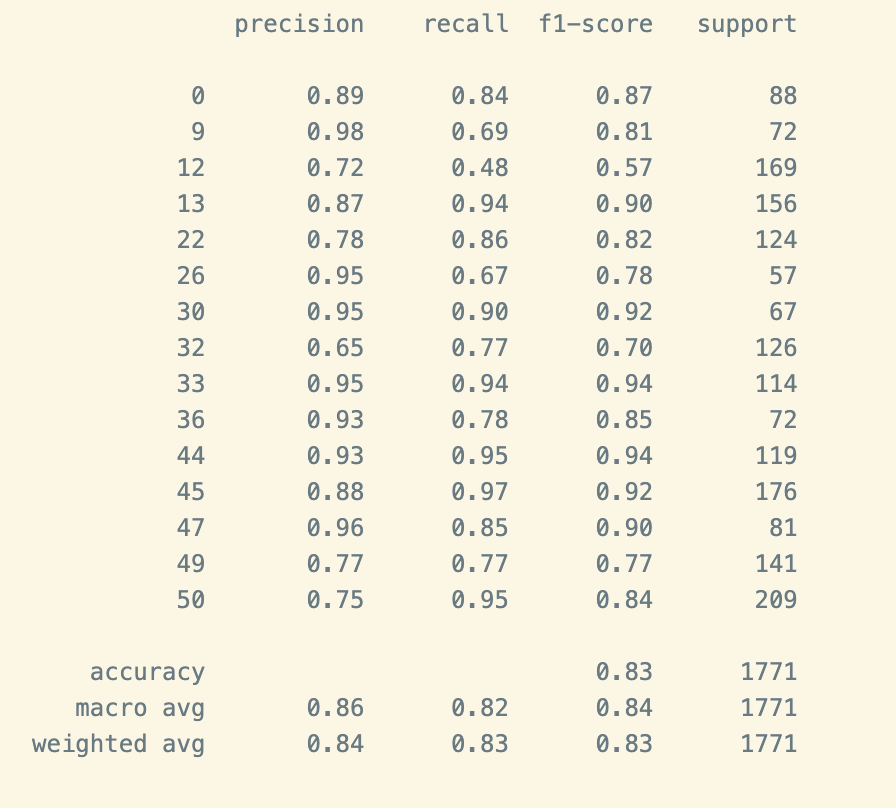


#### Approach #2:  HuggingFace - DistilBert

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="Falconsai/intent_classification")
text = "Your text to classify here."
result = classifier(text)